<a href="https://colab.research.google.com/github/saminkmathur/saminkmathur/blob/main/Portfolio_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.optimize import minimize

In [20]:
df = pd.read_csv("/content/48_Industry_Portfolios_daily.CSV")

/tmp/ipython-input-951213307.py:1: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,21,22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/48_Industry_Portfolios_daily.CSV")


In [14]:
df.columns = df.columns.str.strip()
# Set the 'Unnamed: 0' column as the index first, as it contains the date information.
df = df.set_index('Unnamed: 0')

# Clean the index (which now contains date strings) to remove non-numeric entries (like the descriptive footer row).
# We will coerce errors, and keep only rows where the index could be converted to numeric.
numeric_index_values = pd.to_numeric(df.index, errors='coerce')
df = df[numeric_index_values.notna()] # Keep rows where the index is not NaN after numeric conversion
df.index = numeric_index_values[numeric_index_values.notna()] # Update the index with the cleaned numeric values

# Convert the cleaned numeric index to datetime objects and set the name
df.index = pd.to_datetime(df.index.astype(int).astype(str), format='%Y%m%d')
df.index.name = 'Date'

# Convert return columns from object to numeric, coerce non-numeric values to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert returns from percentage to decimal and drop any remaining rows with NaN values
df = df.div(100).dropna()

# Select a subset of assets for analysis
asset_names = ["Food", "Chips", "Oil", "Banks", "RlEst"]
returns_df = df[asset_names]
N_ASSETS = len(asset_names)
N_DAYS = 252 # Annualizing factor

# --- Step 2: Analyze Historical Data (Calculate Inputs) ---
mu = returns_df.mean() * N_DAYS # Annualized Mean Returns
S = returns_df.cov() * N_DAYS   # Annualized Covariance Matrix

print("--- 2A. Asset Historical Statistics (Annualized) ---")
individual_volatility = np.sqrt(np.diag(S))
individual_sharpe = mu / individual_volatility

individual_stats = pd.DataFrame({
    'Annualized Return': mu,
    'Annualized Volatility': individual_volatility,
    'Sharpe Ratio (rfr=0)': individual_sharpe
})
print(individual_stats.to_markdown(floatfmt=".4f"))

print("\n--- 2B. Correlation Matrix ---")
correlation_matrix = returns_df.corr()
print(correlation_matrix.to_markdown(floatfmt=".4f"))

# --- Step 3: Optimize Portfolio Allocation (Using scipy.optimize) ---

# Helper functions for optimization
def portfolio_volatility(weights, S):
    """Calculates the portfolio volatility."""
    weights = np.array(weights)
    return np.sqrt(np.dot(weights.T, np.dot(S, weights)))

def portfolio_return(weights, mu):
    """Calculates the portfolio return."""
    weights = np.array(weights)
    return np.dot(weights.T, mu)

def negative_sharpe(weights, mu, S):
    """Objective function for MSR: Minimize negative Sharpe Ratio (rfr=0)."""
    p_ret = portfolio_return(weights, mu)
    p_vol = portfolio_volatility(weights, S)
    # Return a very large number if volatility is near zero to avoid division by zero or large negative Sharpe
    if p_vol < 1e-6:
        return 1e9
    return -p_ret / p_vol

# Constraints and bounds for optimization
# Constraint 1: Sum of weights must equal 1 (Full Investment)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
# Constraint 2: Box constraints (0 <= weight <= 0.5)
bounds = tuple((0.0, 0.5) for _ in range(N_ASSETS))
# Initial guess (Equal Weight)
initial_weights = np.array([1/N_ASSETS] * N_ASSETS)

# 1. Global Minimum Variance Portfolio (GMVP)
opt_gmvp = minimize(portfolio_volatility,
                    initial_weights,
                    args=(S,),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints)
weights_gmvp = pd.Series(opt_gmvp.x, index=asset_names).round(4)

print("\n--- 3A. GMVP Optimal Weights ---")
print(weights_gmvp.to_markdown(floatfmt=".4f"))

# 2. Maximum Sharpe Ratio Portfolio (MSR)
opt_msr = minimize(negative_sharpe,
                   initial_weights,
                   args=(mu, S),
                   method='SLSQP',
                   bounds=bounds,
                   constraints=constraints)
weights_msr = pd.Series(opt_msr.x, index=asset_names).round(4)

print("\n--- 3B. MSR Optimal Weights ---")
print(weights_msr.to_markdown(floatfmt=".4f"))

# --- Step 4: Evaluate Performance ---

# 1. Equal Weight Portfolio (EWP)
weights_ewp = pd.Series([1/N_ASSETS] * N_ASSETS, index=asset_names)

# Helper function to get performance from weights Series
def get_portfolio_performance_series(weights_series, mu, S):
    w = weights_series.values
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(S, w)))
    sharpe = ret / vol
    return ret, vol, sharpe

# Get performance for all three portfolios
perf_gmvp = get_portfolio_performance_series(weights_gmvp, mu, S)
perf_msr = get_portfolio_performance_series(weights_msr, mu, S)
perf_ewp = get_portfolio_performance_series(weights_ewp, mu, S)

# Create the performance table
performance_data = {
    'GMVP': perf_gmvp,
    'MSR': perf_msr,
    'EWP': perf_ewp
}
performance_df = pd.DataFrame.from_dict(
    performance_data,
    orient='index',
    columns=['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio (rfr=0)']
)

print("\n--- 4A. Portfolio Performance Comparison (Annualized) ---")
print(performance_df.to_markdown(floatfmt=".4f"))

# --- 4B. Visualize Cumulative Returns ---

# Calculate daily portfolio returns
portfolio_returns_df = pd.DataFrame(index=returns_df.index)

# Function to calculate weighted daily returns
def calculate_portfolio_returns(daily_returns, weights):
    weights_aligned = weights.reindex(daily_returns.columns).fillna(0)
    return daily_returns.dot(weights_aligned)

portfolio_returns_df['GMVP'] = calculate_portfolio_returns(returns_df, weights_gmvp)
portfolio_returns_df['MSR'] = calculate_portfolio_returns(returns_df, weights_msr)
portfolio_returns_df['EWP'] = calculate_portfolio_returns(returns_df, weights_ewp)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns_df).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca())
plt.title('Cumulative Returns Comparison (GMVP vs MSR vs EWP)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Portfolio Strategy')
plt.tight_layout()

# Save the plot
plt.savefig('cumulative_returns_comparison.png')
plt.close()

print("\n--- 4C. Cumulative Returns Plot Saved ---")

--- 2A. Asset Historical Statistics (Annualized) ---
|       |   Annualized Return |   Annualized Volatility |   Sharpe Ratio (rfr=0) |
|:------|--------------------:|------------------------:|-----------------------:|
| Food  |              0.1574 |                  0.1359 |                 1.1583 |
| Chips |              0.1806 |                  0.2325 |                 0.7765 |
| Oil   |              0.1631 |                  0.2282 |                 0.7145 |
| Banks |              0.1592 |                  0.1833 |                 0.8684 |
| RlEst |              0.1207 |                  0.2255 |                 0.5353 |

--- 2B. Correlation Matrix ---
|       |   Food |   Chips |    Oil |   Banks |   RlEst |
|:------|-------:|--------:|-------:|--------:|--------:|
| Food  | 1.0000 |  0.5728 | 0.5525 |  0.6194 |  0.5217 |
| Chips | 0.5728 |  1.0000 | 0.5233 |  0.6110 |  0.5387 |
| Oil   | 0.5525 |  0.5233 | 1.0000 |  0.5199 |  0.5059 |
| Banks | 0.6194 |  0.6110 | 0.5199 |  1.000

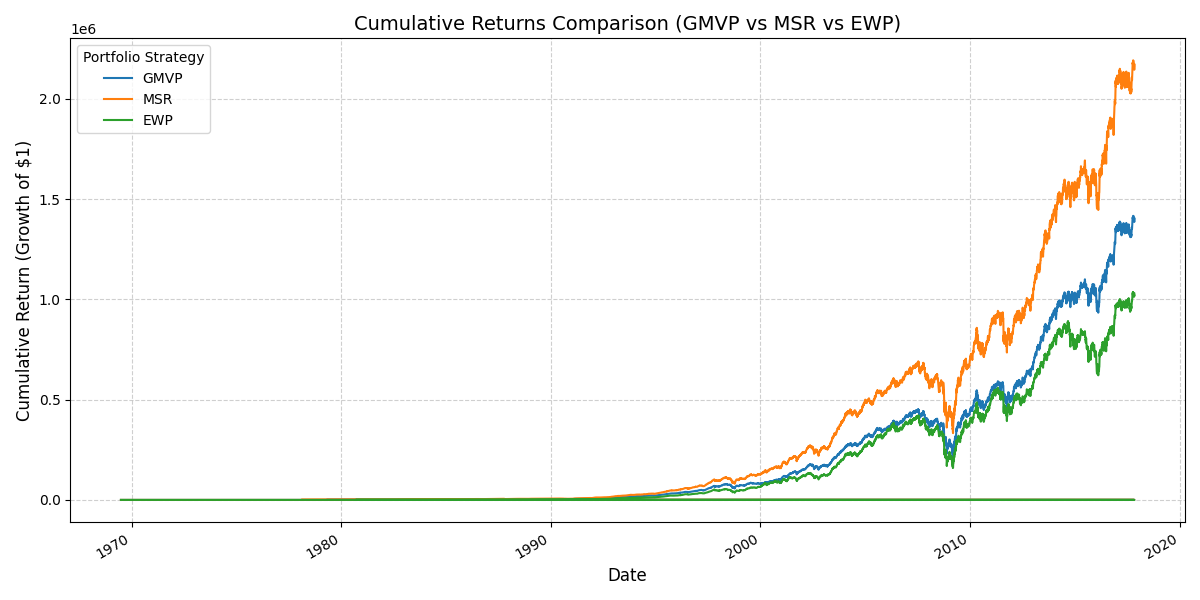

In [15]:
from IPython.display import Image
Image(filename='cumulative_returns_comparison.png')

In [21]:
df.columns = df.columns.str.strip()
# Set the 'Unnamed: 0' column as the index first, as it contains the date information.
df = df.set_index('Unnamed: 0')

# Clean the index (which now contains date strings) to remove non-numeric entries (like the descriptive footer row).
# We will coerce errors, and keep only rows where the index could be converted to numeric.
numeric_index_values = pd.to_numeric(df.index, errors='coerce')
df = df[numeric_index_values.notna()] # Keep rows where the index is not NaN after numeric conversion
df.index = numeric_index_values[numeric_index_values.notna()] # Update the index with the cleaned numeric values

# Convert the cleaned numeric index to datetime objects and set the name
df.index = pd.to_datetime(df.index.astype(int).astype(str), format='%Y%m%d')
df.index.name = 'Date'

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.div(100).dropna() # Convert to decimal returns and drop NaNs

asset_names = ["Food", "Chips", "Oil", "Banks", "RlEst"]
returns_df = df[asset_names]
N_ASSETS = len(asset_names)
N_DAYS = 252

# --- 2. Historical Data Analysis (Inputs) ---
mu = returns_df.mean() * N_DAYS # Annualized Mean Returns
S = returns_df.cov() * N_DAYS   # Annualized Covariance Matrix

# --- 3. Optimization Functions ---
def portfolio_volatility(weights, S):
    weights = np.array(weights)
    return np.sqrt(np.dot(weights.T, np.dot(S, weights)))

def portfolio_return(weights, mu):
    weights = np.array(weights)
    return np.dot(weights.T, mu)

def negative_sharpe(weights, mu, S):
    p_ret = portfolio_return(weights, mu)
    p_vol = portfolio_volatility(weights, S)
    if p_vol < 1e-6:
        return 1e9
    return -p_ret / p_vol

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0.0, 0.5) for _ in range(N_ASSETS))
initial_weights = np.array([1/N_ASSETS] * N_ASSETS)

# GMVP Optimization
opt_gmvp = minimize(portfolio_volatility, initial_weights, args=(S,), method='SLSQP', bounds=bounds, constraints=constraints)
weights_gmvp = pd.Series(opt_gmvp.x, index=asset_names).round(4)

# MSR Optimization
opt_msr = minimize(negative_sharpe, initial_weights, args=(mu, S), method='SLSQP', bounds=bounds, constraints=constraints)
weights_msr = pd.Series(opt_msr.x, index=asset_names).round(4)

# --- 4. Performance Evaluation ---
weights_ewp = pd.Series([1/N_ASSETS] * N_ASSETS, index=asset_names)

def get_portfolio_performance_series(weights_series, mu, S):
    w = weights_series.values
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(S, w)))
    sharpe = ret / vol
    return ret, vol, sharpe

# Get performance for all three portfolios
perf_gmvp = get_portfolio_performance_series(weights_gmvp, mu, S)
perf_msr = get_portfolio_performance_series(weights_msr, mu, S)
perf_ewp = get_portfolio_performance_series(weights_ewp, mu, S)

# Create the performance table
performance_data = {
    'GMVP': perf_gmvp,
    'MSR': perf_msr,
    'EWP': perf_ewp
}
performance_df = pd.DataFrame.from_dict(
    performance_data,
    orient='index',
    columns=['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio (rfr=0)']
)

# Plotting cumulative returns
# Calculate daily portfolio returns
portfolio_returns_df = pd.DataFrame(index=returns_df.index)

# Function to calculate weighted daily returns
def calculate_portfolio_returns(daily_returns, weights):
    weights_aligned = weights.reindex(daily_returns.columns).fillna(0)
    return daily_returns.dot(weights_aligned)

portfolio_returns_df['GMVP'] = calculate_portfolio_returns(returns_df, weights_gmvp)
portfolio_returns_df['MSR'] = calculate_portfolio_returns(returns_df, weights_msr)
portfolio_returns_df['EWP'] = calculate_portfolio_returns(returns_df, weights_ewp)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns_df).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca())
plt.title('Cumulative Returns Comparison (GMVP vs MSR vs EWP)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Portfolio Strategy')
plt.tight_layout()

# Save the plot
plt.savefig('cumulative_returns_comparison.png')
plt.close()

In [27]:
# Define the new risk-free rate for this exploration
rfr = 0.03

print(f"--- Recalculating performance with Risk-Free Rate = {rfr*100:.0f}% ---")

# 2. Maximum Sharpe Ratio Portfolio (MSR) with new rfr
opt_msr_rfr_new = minimize(negative_sharpe_with_rfr,
                   initial_weights,
                   args=(mu, S, rfr),
                   method='SLSQP',
                   bounds=bounds,
                   constraints=constraints)
weights_msr_rfr_new = pd.Series(opt_msr_rfr_new.x, index=asset_names).round(4)

print("\n--- 3B. MSR Optimal Weights (rfr=3%) ---")
print(weights_msr_rfr_new.to_markdown(floatfmt=".4f"))

# Get performance for all three portfolios with the new rfr
perf_gmvp_rfr_new = get_portfolio_performance_series_with_rfr(weights_gmvp, mu, S, rfr)
perf_msr_rfr_new = get_portfolio_performance_series_with_rfr(weights_msr_rfr_new, mu, S, rfr)
perf_ewp_rfr_new = get_portfolio_performance_series_with_rfr(weights_ewp, mu, S, rfr)

# Create the performance table with rfr
performance_data_rfr_new = {
    'GMVP (rfr=3%)': perf_gmvp_rfr_new,
    'MSR (rfr=3%)': perf_msr_rfr_new,
    'EWP (rfr=3%)': perf_ewp_rfr_new
}
performance_df_rfr_new = pd.DataFrame.from_dict(
    performance_data_rfr_new,
    orient='index',
    columns=['Annualized Return', 'Annualized Volatility', f'Sharpe Ratio (rfr={rfr*100:.0f}%)']
)

print("\n--- 4A. Portfolio Performance Comparison (Annualized, rfr=3%) ---")
print(performance_df_rfr_new.to_markdown(floatfmt=".4f"))

--- Recalculating performance with Risk-Free Rate = 3% ---

--- 3B. MSR Optimal Weights (rfr=3%) ---
|       |      0 |
|:------|-------:|
| Food  | 0.5000 |
| Chips | 0.1263 |
| Oil   | 0.0939 |
| Banks | 0.2798 |
| RlEst | 0.0000 |

--- 4A. Portfolio Performance Comparison (Annualized, rfr=3%) ---
|               |   Annualized Return |   Annualized Volatility |   Sharpe Ratio (rfr=3%) |
|:--------------|--------------------:|------------------------:|------------------------:|
| GMVP (rfr=3%) |              0.1563 |                  0.1413 |                  0.8936 |
| MSR (rfr=3%)  |              0.1614 |                  0.1429 |                  0.9191 |
| EWP (rfr=3%)  |              0.1562 |                  0.1618 |                  0.7800 |


In [26]:
# Define the new risk-free rate
rfr = 0.02

print(f"--- Recalculating performance with Risk-Free Rate = {rfr*100:.0f}% ---")

# --- 3. Optimization Functions (updated for rfr) ---

def negative_sharpe_with_rfr(weights, mu, S, rfr):
    """Objective function for MSR: Minimize negative Sharpe Ratio (with rfr)."""
    p_ret = portfolio_return(weights, mu)
    p_vol = portfolio_volatility(weights, S)
    if p_vol < 1e-6:
        return 1e9 # Return a very large number if volatility is near zero
    return -(p_ret - rfr) / p_vol

# Constraints and bounds (re-using existing ones)
# initial_weights (re-using existing one)

# 2. Maximum Sharpe Ratio Portfolio (MSR) with new rfr
opt_msr_rfr = minimize(negative_sharpe_with_rfr,
                   initial_weights,
                   args=(mu, S, rfr),
                   method='SLSQP',
                   bounds=bounds,
                   constraints=constraints)
weights_msr_rfr = pd.Series(opt_msr_rfr.x, index=asset_names).round(4)

print("\n--- 3B. MSR Optimal Weights (rfr=2%) ---")
print(weights_msr_rfr.to_markdown(floatfmt=".4f"))

# --- 4. Performance Evaluation (updated for rfr) ---

def get_portfolio_performance_series_with_rfr(weights_series, mu, S, rfr):
    w = weights_series.values
    ret = np.dot(w, mu)
    vol = np.sqrt(np.dot(w.T, np.dot(S, w)))
    # Calculate Sharpe Ratio using the provided risk-free rate
    sharpe = (ret - rfr) / vol
    return ret, vol, sharpe

# Get performance for all three portfolios with the new rfr
perf_gmvp_rfr = get_portfolio_performance_series_with_rfr(weights_gmvp, mu, S, rfr)
perf_msr_rfr = get_portfolio_performance_series_with_rfr(weights_msr_rfr, mu, S, rfr)
perf_ewp_rfr = get_portfolio_performance_series_with_rfr(weights_ewp, mu, S, rfr)

# Create the performance table with rfr
performance_data_rfr = {
    'GMVP (rfr=2%)': perf_gmvp_rfr,
    'MSR (rfr=2%)': perf_msr_rfr,
    'EWP (rfr=2%)': perf_ewp_rfr
}
performance_df_rfr = pd.DataFrame.from_dict(
    performance_data_rfr,
    orient='index',
    columns=['Annualized Return', 'Annualized Volatility', f'Sharpe Ratio (rfr={rfr*100:.0f}%)']
)

print("\n--- 4A. Portfolio Performance Comparison (Annualized, rfr=2%) ---")
print(performance_df_rfr.to_markdown(floatfmt=".4f"))

--- Recalculating performance with Risk-Free Rate = 2% ---

--- 3B. MSR Optimal Weights (rfr=2%) ---
|       |      0 |
|:------|-------:|
| Food  | 0.5000 |
| Chips | 0.1191 |
| Oil   | 0.0952 |
| Banks | 0.2857 |
| RlEst | 0.0000 |

--- 4A. Portfolio Performance Comparison (Annualized, rfr=2%) ---
|               |   Annualized Return |   Annualized Volatility |   Sharpe Ratio (rfr=2%) |
|:--------------|--------------------:|------------------------:|------------------------:|
| GMVP (rfr=2%) |              0.1563 |                  0.1413 |                  0.9644 |
| MSR (rfr=2%)  |              0.1612 |                  0.1428 |                  0.9891 |
| EWP (rfr=2%)  |              0.1562 |                  0.1618 |                  0.8418 |


In [24]:
print("--- GMVP Optimal Weights ---")
display(weights_gmvp)

--- GMVP Optimal Weights ---


,0
Food,0.5000
Chips,0.0126
Oil,0.0970
Banks,0.3214
RlEst,0.0690


In [25]:
print("--- MSR Optimal Weights ---")
display(weights_msr)

--- MSR Optimal Weights ---


,0
Food,0.5000
Chips,0.1077
Oil,0.0968
Banks,0.2955
RlEst,0.0000


In [23]:
display(performance_df.loc[['GMVP', 'MSR']])

,Annualized Return,Annualized Volatility,Sharpe Ratio (rfr=0)
GMVP,0.156281,0.141318,1.105882
MSR,0.160968,0.142531,1.129355


In [22]:
display(individual_stats)

,Annualized Return,Annualized Volatility,Sharpe Ratio (rfr=0)
Food,0.157385,0.135877,1.158290
Chips,0.180569,0.232537,0.776515
Oil,0.163056,0.228216,0.714482
Banks,0.159204,0.183338,0.868359
RlEst,0.120711,0.225486,0.535338


# Task
Create a line plot showing how the Sharpe Ratios of GMVP, MSR, and EWP portfolios change with different risk-free rates (0%, 2%, and 3%). The plot should have 'Risk-Free Rate' on the x-axis and 'Sharpe Ratio' on the y-axis, with each portfolio type represented by a distinct line. Title the plot 'Sharpe Ratio vs. Risk-Free Rate for Different Portfolios', label the axes, include a legend, and save the plot as 'sharpe_ratio_vs_rfr.png'. Finally, display the plot and provide a summary of the observations from the plot, explaining how the Sharpe Ratios of different portfolios respond to changes in the risk-free rate.

## Extract Sharpe Ratios

### Subtask:
Extract the Sharpe Ratios for GMVP, MSR, and EWP from the `performance_df`, `performance_df_rfr`, and `performance_df_rfr_new` DataFrames, corresponding to risk-free rates of 0%, 2%, and 3% respectively.


**Reasoning**:
Extract the Sharpe Ratios for GMVP, MSR, and EWP from the three performance DataFrames, corresponding to risk-free rates of 0%, 2%, and 3% respectively, and store them in individual variables as requested.



In [28]:
sharpe_gmvp_rfr0 = performance_df.loc['GMVP', 'Sharpe Ratio (rfr=0)']
sharpe_msr_rfr0 = performance_df.loc['MSR', 'Sharpe Ratio (rfr=0)']
sharpe_ewp_rfr0 = performance_df.loc['EWP', 'Sharpe Ratio (rfr=0)']

sharpe_gmvp_rfr2 = performance_df_rfr.loc['GMVP (rfr=2%)', 'Sharpe Ratio (rfr=2%)']
sharpe_msr_rfr2 = performance_df_rfr.loc['MSR (rfr=2%)', 'Sharpe Ratio (rfr=2%)']
sharpe_ewp_rfr2 = performance_df_rfr.loc['EWP (rfr=2%)', 'Sharpe Ratio (rfr=2%)']

sharpe_gmvp_rfr3 = performance_df_rfr_new.loc['GMVP (rfr=3%)', 'Sharpe Ratio (rfr=3%)']
sharpe_msr_rfr3 = performance_df_rfr_new.loc['MSR (rfr=3%)', 'Sharpe Ratio (rfr=3%)']
sharpe_ewp_rfr3 = performance_df_rfr_new.loc['EWP (rfr=3%)', 'Sharpe Ratio (rfr=3%)']

print("Sharpe Ratios (rfr=0%):")
print(f"  GMVP: {sharpe_gmvp_rfr0:.4f}")
print(f"  MSR:  {sharpe_msr_rfr0:.4f}")
print(f"  EWP:  {sharpe_ewp_rfr0:.4f}")

print("\nSharpe Ratios (rfr=2%):")
print(f"  GMVP: {sharpe_gmvp_rfr2:.4f}")
print(f"  MSR:  {sharpe_msr_rfr2:.4f}")
print(f"  EWP:  {sharpe_ewp_rfr2:.4f}")

print("\nSharpe Ratios (rfr=3%):")
print(f"  GMVP: {sharpe_gmvp_rfr3:.4f}")
print(f"  MSR:  {sharpe_msr_rfr3:.4f}")
print(f"  EWP:  {sharpe_ewp_rfr3:.4f}")

Sharpe Ratios (rfr=0%):
  GMVP: 1.1059
  MSR:  1.1294
  EWP:  0.9655

Sharpe Ratios (rfr=2%):
  GMVP: 0.9644
  MSR:  0.9891
  EWP:  0.8418

Sharpe Ratios (rfr=3%):
  GMVP: 0.8936
  MSR:  0.9191
  EWP:  0.7800


**Reasoning**:
Consolidate the extracted Sharpe Ratios for each portfolio across the different risk-free rates into a single DataFrame to prepare for plotting.

